In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flight-price-prediction/business.csv
/kaggle/input/flight-price-prediction/economy.csv
/kaggle/input/flight-price-prediction/Clean_Dataset.csv


# Introduction

In this project, we are working with a dataset about flight prices. The data includes information such as the airline, departure and arrival times, duration of the journey, number of stops, and the ticket price.

Our goal is to explore the dataset, clean and prepare it for analysis and then build machine learning models that can predict the price of a flight. By doing this, we hope to better understand what factors influence flight prices the most.

## Goals of the analysis

The first step is to explore and preprocess the data. This means handling missing values, converting time-related columns into usable formats, and transforming categorical information like airlines and routes into numerical form so that it can be used in our models. We will also create some visualizations to see if there are any obvious relationships between factors such as duration, number of stops, or airlines and the price of the flight.

The target variable we want to predict is the ticket price. To do this, we will build and compare two different regression models:

Linear Regression, which is a simple model that assumes a straight-line relationship between the input features and the price.

Random Forest Regression, which is a more advanced model that uses multiple decision trees to capture more complex patterns in the data.

We will then evaluate how well these models perform using metrics such as Mean Absolute Error (MAE), which shows how far off the predictions are from the actual prices on average, and R² (Coefficient of Determination), which measures how much of the variation in price our models can explain.

Finally, we will analyze the importance of different features to see which factors have the strongest influence on flight prices.

## Expected outcome

By the end of this project, we will be able to recommend which regression model is best suited for predicting flight ticket prices. We will also be able to rank the dataset’s features to show which ones are most important for determining the cost of a flight.


# Importing dependancies

In [2]:
# Import dependencies
import pandas as pd        
import numpy as np         
import matplotlib.pyplot as plt  
import seaborn as sns 

from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import OneHotEncoder, StandardScaler  
from sklearn.compose import ColumnTransformer  
from sklearn.pipeline import Pipeline         
from sklearn.impute import SimpleImputer       
from sklearn.linear_model import LinearRegression  
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_absolute_error, r2_score 


# Load and combine flight price datasets

In [3]:

# Load both datasets
business = pd.read_csv("/kaggle/input/flight-price-prediction/business.csv")
economy  = pd.read_csv("/kaggle/input/flight-price-prediction/economy.csv")

# Combine datasets into one
data = pd.concat([business, economy], ignore_index=True)

# Show dimensions
print("Shape:", data.shape)



Shape: (300261, 11)


# Inspecting Dataset Structure

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        300261 non-null  object
 1   airline     300261 non-null  object
 2   ch_code     300261 non-null  object
 3   num_code    300261 non-null  int64 
 4   dep_time    300261 non-null  object
 5   from        300261 non-null  object
 6   time_taken  300261 non-null  object
 7   stop        300261 non-null  object
 8   arr_time    300261 non-null  object
 9   to          300261 non-null  object
 10  price       300261 non-null  object
dtypes: int64(1), object(10)
memory usage: 25.2+ MB


## Exploring Columns and Previewing Data 

In [5]:
print(data.columns.tolist())

['date', 'airline', 'ch_code', 'num_code', 'dep_time', 'from', 'time_taken', 'stop', 'arr_time', 'to', 'price']


In [6]:
# Check the first 5 rows
data.head(5)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612"
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612"
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220"
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450"
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690"


## Visualizing Relationships in the Dataset

To better understand the data before preprocessing, we visualize how ticket prices vary across some key features such as the number of stops, airline, and flight duration.


### The plot shows that flights with 0 stops tend to be cheaper and more consistent in price, 
while flights with 1 or 2 stops have higher variation and can reach significantly higher prices.


## Statistical Summary of Numerical Features

In [7]:
# Statical summary
data.describe()

,num_code
count,300261.000000
mean,1417.771709
std,1974.514439
min,101.000000
25%,637.000000
50%,818.000000
75%,927.000000
max,9991.000000


In [8]:
print(data.columns.tolist())

['date', 'airline', 'ch_code', 'num_code', 'dep_time', 'from', 'time_taken', 'stop', 'arr_time', 'to', 'price']


## Exploring Categorical Features in the Dataset

In [9]:
categorical = data.dtypes[data.dtypes == "object"].index
print(categorical)

data[categorical].describe()

Index(['date', 'airline', 'ch_code', 'dep_time', 'from', 'time_taken', 'stop',
       'arr_time', 'to', 'price'],
      dtype='object')


,date,airline,ch_code,dep_time,from,time_taken,stop,arr_time,to,price
count,300261,300261,300261,300261,300261,300261,300261,300261,300261,300261
unique,49,8,8,251,6,483,40,266,6,12165
top,07-03-2022,Vistara,UK,07:00,Delhi,02h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,19:55,Mumbai,"54,608"
freq,6633,127859,127859,8760,61345,4242,243603,9194,59109,1445


## Understanding and processing the dataset

## Variable Description

- **Airline**: Name of the airline company (categorical, 6 unique airlines).  
- **Flight(ch_code)**: Flight code/identifier of the plane (categorical).  
- **Source City**: The city where the flight departs from (categorical, 6 unique cities).  
- **Departure Time**: Time of departure grouped into 6 time intervals (categorical).  
- **Stops**: Number of stops between source and destination (categorical, 3 values).  
- **Arrival Time**: Time of arrival grouped into 6 time intervals (categorical).  
- **Destination City**: The city where the flight lands (categorical, 6 unique cities).  
- **Class**: Seat class of the ticket – Business or Economy (categorical, 2 values).  
- **Duration**: Total travel time between cities (continuous, in hours).  
- **Days Left**: Number of days between booking date and trip date (continuous, derived feature).  
- **Price**: Ticket price (target variable, continuous).  


## Drop unnecessary columns

In [10]:
irrelevant_cols = ["ch_code", "num_code"]
data = data.drop(columns=irrelevant_cols, errors="ignore")
print(data.columns.tolist())


['date', 'airline', 'dep_time', 'from', 'time_taken', 'stop', 'arr_time', 'to', 'price']


In [11]:
print(data.columns.tolist())

['date', 'airline', 'dep_time', 'from', 'time_taken', 'stop', 'arr_time', 'to', 'price']


## Convert price to numerical values

In [12]:
data["price"] = data["price"].str.replace(",", "")

data["price"] = pd.to_numeric(data["price"], errors="coerce")

data["price"].head()

0    25612
1    25612
2    42220
3    44450
4    46690
Name: price, dtype: int64

In [13]:
print(data.columns.tolist())

['date', 'airline', 'dep_time', 'from', 'time_taken', 'stop', 'arr_time', 'to', 'price']


## Convert flight duration into minutes

In [14]:
# Extract hours and minutes, fill NaN with 0
data["hours"] = data["time_taken"].str.extract(r'(\d+)h').fillna(0).astype(int)
data["minutes"] = data["time_taken"].str.extract(r'(\d+)m').fillna(0).astype(int)

# Calculate total duration in minutes
data["duration_min"] = data["hours"] * 60 + data["minutes"]

# Check the result
print(data[["time_taken", "duration_min"]].head())


  time_taken  duration_min
0    02h 00m           120
1    02h 15m           135
2    24h 45m          1485
3    26h 30m          1590
4    06h 40m           400


In [15]:
print(data.columns.tolist())

['date', 'airline', 'dep_time', 'from', 'time_taken', 'stop', 'arr_time', 'to', 'price', 'hours', 'minutes', 'duration_min']


## Convert number of stops to numeric values

In [16]:
# Extract the number from "1-stop", "2-stops", etc.
data["stops"] = data["stop"].str.extract(r'(\d+)').fillna(0).astype(int)

# Check the result
print(data[["stop", "stops"]].head(10))



                                                stop  stops
0                                          non-stop       0
1                                          non-stop       0
2  1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...      1
3  1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...      1
4  1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...      1
5                                          non-stop       0
6  1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...      1
7  1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...      1
8  1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...      1
9                                          non-stop       0


In [17]:
print(data.columns.tolist())

['date', 'airline', 'dep_time', 'from', 'time_taken', 'stop', 'arr_time', 'to', 'price', 'hours', 'minutes', 'duration_min', 'stops']


## Processing the Stop Column

In [18]:
data["stop"] = data["stop"].str.replace(r"[\n\t]", "", regex=True).str.strip()

print(data[["stop", "stops"]].head(10))

       stop  stops
0  non-stop      0
1  non-stop      0
2    1-stop      1
3    1-stop      1
4    1-stop      1
5  non-stop      0
6    1-stop      1
7    1-stop      1
8    1-stop      1
9  non-stop      0


In [19]:
print(data.columns.tolist())

['date', 'airline', 'dep_time', 'from', 'time_taken', 'stop', 'arr_time', 'to', 'price', 'hours', 'minutes', 'duration_min', 'stops']


## Converting Categorical and Date Features to Numerical Values

In [20]:
data["date"] = pd.to_datetime(data["date"], format='%d-%m-%Y', errors="coerce")

# Create new features
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["weekday"] = data["date"].dt.weekday

print(data[["date", "year", "month", "weekday"]].head())

        date  year  month  weekday
0 2022-02-11  2022      2        4
1 2022-02-11  2022      2        4
2 2022-02-11  2022      2        4
3 2022-02-11  2022      2        4
4 2022-02-11  2022      2        4


In [21]:
print(data.columns.tolist())

['date', 'airline', 'dep_time', 'from', 'time_taken', 'stop', 'arr_time', 'to', 'price', 'hours', 'minutes', 'duration_min', 'stops', 'year', 'month', 'weekday']


In [22]:
# Extract the hour directly without keeping the full datetime
data["dep_hour"] = pd.to_datetime(data["dep_time"], format="%H:%M", errors="coerce").dt.hour
data["arr_hour"] = pd.to_datetime(data["arr_time"], format="%H:%M", errors="coerce").dt.hour

# Drop the original string columns if they are no longer needed
data = data.drop(columns=["dep_time", "arr_time"])

print(data[["dep_hour", "arr_hour"]].head())



   dep_hour  arr_hour
0        18        20
1        19        21
2        20        20
3        21        23
4        17        23


In [23]:
print(data.columns.tolist())

['date', 'airline', 'from', 'time_taken', 'stop', 'to', 'price', 'hours', 'minutes', 'duration_min', 'stops', 'year', 'month', 'weekday', 'dep_hour', 'arr_hour']


In [24]:
new_features = ["duration_min", "stops", "year", "month", "weekday", "dep_hour", "arr_hour"]

print(data[new_features].head())   

   duration_min  stops  year  month  weekday  dep_hour  arr_hour
0           120      0  2022      2        4        18        20
1           135      0  2022      2        4        19        21
2          1485      1  2022      2        4        20        20
3          1590      1  2022      2        4        21        23
4           400      1  2022      2        4        17        23


In [25]:
print(data.columns.tolist())


['date', 'airline', 'from', 'time_taken', 'stop', 'to', 'price', 'hours', 'minutes', 'duration_min', 'stops', 'year', 'month', 'weekday', 'dep_hour', 'arr_hour']


### One-Hot Encoding for Categorical Features

In [26]:
# Select the columns that are categorical
categorical_cols = ["airline", "from", "to"]

# Apply one-hot encoding (creates new columns.)
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Display the result
print(data.columns.tolist())
print(data.head())



['date', 'time_taken', 'stop', 'price', 'hours', 'minutes', 'duration_min', 'stops', 'year', 'month', 'weekday', 'dep_hour', 'arr_hour', 'airline_AirAsia', 'airline_GO FIRST', 'airline_Indigo', 'airline_SpiceJet', 'airline_StarAir', 'airline_Trujet', 'airline_Vistara', 'from_Chennai', 'from_Delhi', 'from_Hyderabad', 'from_Kolkata', 'from_Mumbai', 'to_Chennai', 'to_Delhi', 'to_Hyderabad', 'to_Kolkata', 'to_Mumbai']
        date time_taken      stop  price  hours  minutes  duration_min  stops  \
0 2022-02-11    02h 00m  non-stop  25612      2        0           120      0   
1 2022-02-11    02h 15m  non-stop  25612      2       15           135      0   
2 2022-02-11    24h 45m    1-stop  42220     24       45          1485      1   
3 2022-02-11    26h 30m    1-stop  44450     26       30          1590      1   
4 2022-02-11    06h 40m    1-stop  46690      6       40           400      1   

   year  month  ...  from_Chennai  from_Delhi  from_Hyderabad  from_Kolkata  \
0  2022      2  

In [27]:
print(data.dtypes)


date                datetime64[ns]
time_taken                  object
stop                        object
price                        int64
hours                        int64
minutes                      int64
duration_min                 int64
stops                        int64
year                         int32
month                        int32
weekday                      int32
dep_hour                     int32
arr_hour                     int32
airline_AirAsia               bool
airline_GO FIRST              bool
airline_Indigo                bool
airline_SpiceJet              bool
airline_StarAir               bool
airline_Trujet                bool
airline_Vistara               bool
from_Chennai                  bool
from_Delhi                    bool
from_Hyderabad                bool
from_Kolkata                  bool
from_Mumbai                   bool
to_Chennai                    bool
to_Delhi                      bool
to_Hyderabad                  bool
to_Kolkata          

### Drop Irrelevant Columns

In [28]:
# Drop irrelevant columns (ignore if they are already removed)
data = data.drop(columns=["time_taken", "stop", "hours", "minutes", "date"], errors="ignore")

# Check which columns remain
print(data.columns.tolist())




['price', 'duration_min', 'stops', 'year', 'month', 'weekday', 'dep_hour', 'arr_hour', 'airline_AirAsia', 'airline_GO FIRST', 'airline_Indigo', 'airline_SpiceJet', 'airline_StarAir', 'airline_Trujet', 'airline_Vistara', 'from_Chennai', 'from_Delhi', 'from_Hyderabad', 'from_Kolkata', 'from_Mumbai', 'to_Chennai', 'to_Delhi', 'to_Hyderabad', 'to_Kolkata', 'to_Mumbai']


## Outlier Detection in Ticket Prices

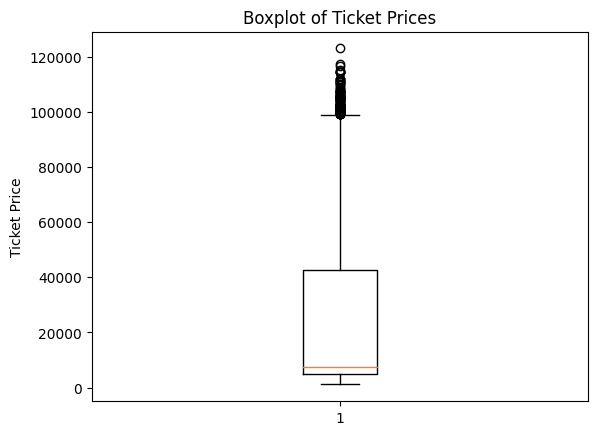

Shape after outlier removal: (300138, 25)


In [29]:

# boxplot of the ticket prices
plt.boxplot(data["price"])
plt.title("Boxplot of Ticket Prices")
plt.ylabel("Ticket Price")
plt.show()

# Outlier Removal using IQR (Interquartile Range) 
Q1 = data["price"].quantile(0.25)
Q3 = data["price"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Keep only the rows where price is within the allowed range
data = data[(data["price"] >= lower) & (data["price"] <= upper)]

print("Shape after outlier removal:", data.shape)



### Checking the dataset size after removal

In [30]:
print("Shape after outlier removal:", data.shape)


Shape after outlier removal: (300138, 25)


### Define Target Variable and Features

In [31]:
# Set the target variable (what we want to predict)
y = data["price"]

# Set the features (all columns except 'price')
X = data.drop(columns=["price"])

# Check the dimensions of features and target
print("X shape:", X.shape)
print("y shape:", y.shape)



X shape: (300138, 24)
y shape: (300138,)


### Split the Dataset into Training and Testing Sets

In [32]:
# Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check the shapes of the splits
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (240110, 24) (240110,)
Test shape: (60028, 24) (60028,)


# Algorithm 1: Linear Regression Model

## Train Linear Regression Model

In [33]:
# Create the model
lr = LinearRegression()

# Train the model on the training data
lr.fit(X_train, y_train)

# Make predictions on both training and test data
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)



## Evaluate Linear Regression Performance

In [34]:
# Evaluate model performance using R² and MAE
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))

# Print model intercept
print("Intercept:", lr.intercept_)

Train R²: 0.2372207162056441
Test R²: 0.23620541424252028
Train MAE: 16030.113307933807
Test MAE: 16057.232480189063
Intercept: 30114.85386939161


## Residual Plot for Linear Regression Model

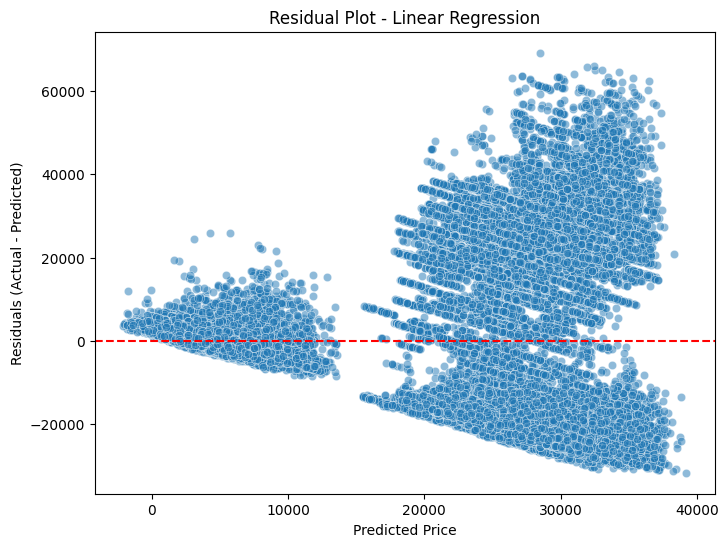

In [35]:

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_pred, y=(y_test - y_test_pred), alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot - Linear Regression")
plt.show()


# Algorithm 2: Random Forest Regressor

## Train Random Forest Regressor

In [36]:
reg = RandomForestRegressor(
    n_estimators=120,
    max_depth=None,     
    min_samples_split=8,
    min_samples_leaf=9,
    random_state=42,
    n_jobs=-1
)

# Train the model on the training data
reg.fit(X_train, y_train)



RandomForestRegressor(min_samples_leaf=9, min_samples_split=8, n_estimators=120,
                      n_jobs=-1, random_state=42)

In [37]:
reg.score(X_test, y_test)



0.297783830786826

## Evaluate Random Forest Model Performance

In [38]:
y_pred = reg.predict(X_test)

y_train_pred = reg.predict(X_train)
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_pred))

print("Test mae:", mean_absolute_error(y_test, y_pred))
print("Train mae:", mean_absolute_error(y_train, y_train_pred))

Train R²: 0.40898498170358233
Test R²: 0.297783830786826
Test mae: 14332.85400405227
Train mae: 13113.584355047888


# Analyzing Feature Importances

In [39]:
reg.feature_importances_


array([2.53526357e-01, 2.38873954e-02, 0.00000000e+00, 1.94805153e-02,
       6.36560170e-02, 5.28069915e-02, 4.84065874e-02, 5.04017473e-02,
       3.50246704e-02, 1.87231466e-02, 3.00359776e-02, 8.33196159e-06,
       8.22992079e-06, 2.90766399e-01, 8.96357385e-03, 1.41833357e-02,
       8.13625911e-03, 1.25837670e-02, 1.43874056e-02, 1.14802426e-02,
       9.27348414e-03, 1.01931157e-02, 8.57030739e-03, 1.54961423e-02])

In [40]:
reg.feature_importances_.shape, X_train.shape # Both the train and test has the same amount of important features (24)

((24,), (240110, 24))

In [41]:
reg.feature_importances_.sum() # The sum of all the features should always be 1.0

1.0

### Table for the features and their importans

In [42]:
feature_importances = pd.DataFrame([X.columns, reg.feature_importances_]).T

feature_importances.columns = ["Feature", "Importance"]

feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

feature_importances

,Feature,Importance
13,airline_Vistara,0.290766
0,duration_min,0.253526
4,weekday,0.063656
5,dep_hour,0.052807
7,airline_AirAsia,0.050402
6,arr_hour,0.048407
8,airline_GO FIRST,0.035025
10,airline_SpiceJet,0.030036
1,stops,0.023887
3,month,0.019481


<Axes: xlabel='Importance', ylabel='Feature'>

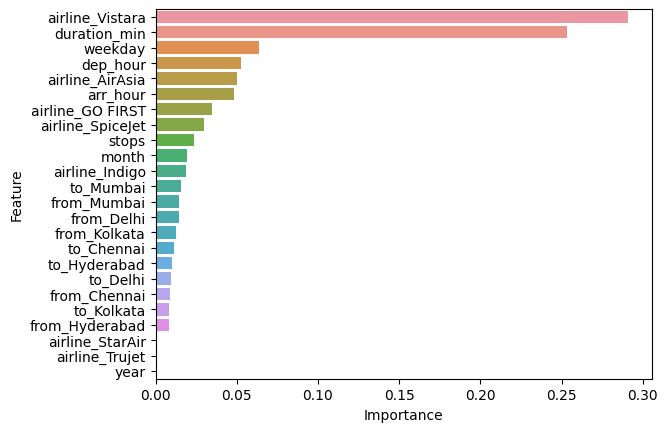

In [43]:
sns.barplot(data=feature_importances, x = "Importance", y = "Feature") #chart table

# Conclusion

In this project, we explored a flight price dataset, cleaned and preprocessed the data, and built two regression models: Linear Regression and Random Forest Regression. Random Forest performed better overall, with higher R² and lower MAE, although both models had some limitations. We also tested different restrictions on the Random Forest model (such as tree depth and minimum samples) to see how the results changed and to achieve a more balanced outcome. Finally, the feature importance analysis showed that airline, duration, and number of stops were the most influential factors in predicting ticket prices.